# Maxcut by QAOA and Quantum annealer

# 1. Graph definition

In [ ]:
import networkx as nx
from itertools import chain, combinations
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize

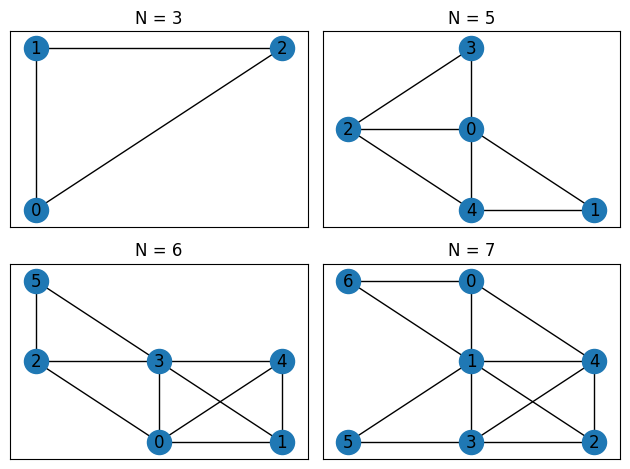

In [648]:
edgelists = [[(0, 1), (0, 2), (1, 2)], 
             [(0, 1), (0, 2), (0, 3), (0, 4), (1, 4), (2, 3), (2, 4)], 
             [(0, 1), (0, 2), (0, 3), (0, 4), (1, 3), (1, 4), (2, 3), (2, 5), (3, 4), (3, 5)],
             [(0, 1), (0, 4), (0, 6), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 3), (2, 4), (3, 4), (3, 5)]]

coordinate_list = [[(0, 0), (0, 1), (1, 1)],
                   [(1, 1), (2, 0), (0, 1), (1, 2), (1, 0)],
                   [(1, 0), (2, 0), (0, 1), (1, 1), (2, 1), (0, 2)],
                   [(1, 2), (1, 1), (2, 0), (1, 0), (2, 1), (0, 0), (0, 2)]]

# List of graphs from the edge list
G_set = [nx.from_edgelist(edgelist) for edgelist in edgelists]

# List of adjacency matrices
matrices_adj = [np.array(nx.adjacency_matrix(G).todense().tolist()) for G in G_set]

fig, axs = plt.subplots(2, 2)
for i, ax in enumerate(fig.axes):
    pos = {n: pos for n, pos in enumerate(coordinate_list[i])}  
    nx.draw_networkx(G_set[i], pos, ax=ax)
    ax.set_title("N = {}".format(len(G_set[i].nodes())))

# fig.suptitle("Graphs of Interest")
plt.tight_layout()
plt.show()

# 2. Classical calculation

In [ ]:
from itertools import combinations

def get_max_cut(G):
    """
    Computes the maximum cut of a given graph G, along with the partitions that produce it.
    
    A maximum cut of a graph is a way of dividing its nodes into two disjoint subsets, 
    maximizing the number of edges between these two subsets. This function identifies 
    such a cut and returns the associated partition of nodes.

    Parameters:
    ----------
    G : Graph (networkx.Graph)
        An undirected graph from the NetworkX library, where nodes represent the vertices
        and edges represent the connections between them.

    Returns:
    -------
    tuple:
        max_cut : int
            The size of the maximum cut, which is the count of edges that exist 
            between the two subsets of nodes in the graph.
        
        max_cut_partitions : list
            A list of partitions (each a list of lists) that achieve the maximum cut value.
            Each partition divides the nodes into two subsets, and the structure is:
                [ [subset1_nodes], [subset2_nodes] ]
    
    Inner Function:
    ---------------
    two_partitions(lst):
        Helper function to generate all unique two-partition configurations of a list of nodes.
        
        Parameters:
        ----------
        lst : list
            A list of node indices to partition.
        
        Returns:
        -------
        list
            A list of unique two-partition combinations, where each partition is a 
            list containing two subsets of nodes.

    Example:
    -------
    max_cut, max_cut_partitions = get_max_cut(G)
    """

    def two_partitions(lst):
        """
        Generates all unique ways to split the list `lst` into two non-empty subsets.
        
        Parameters:
        ----------
        lst : list
            A list of node indices representing nodes in the graph.
        
        Returns:
        -------
        list
            A list of unique two-partition configurations, each as a list of lists:
            [ [subset1], [subset2] ]
        """
        result = set()
        
        # Generate all possible combinations for one subset (partition)
        for i in range(1, len(lst)):
            for part1 in combinations(lst, i):
                part1 = set(part1)
                part2 = set(lst) - part1  # The complementary subset
                # Use frozenset for immutability to ensure unique partitions
                parti = frozenset([frozenset(part1), frozenset(part2)])
                result.add(parti)
        
        # Convert partitions back to lists for easier manipulation
        return [list(map(list, parti)) for parti in result]
    
    # Generate all two-partitions of the graph's node set
    partitions = two_partitions(range(len(G.nodes())))
    new_partitions = []

    # Calculate the cut size for each partition and store results
    for part in partitions:
        cut = 0
        for u in part[0]:
            for v in part[1]:
                if G.has_edge(u, v):  # Check if there is an edge between subsets
                    cut += 1
        # Store the partition along with its cut size
        new_partitions.append([cut] + part)

    # Find the maximum cut value and the corresponding partitions
    max_cut = max(partition[0] for partition in new_partitions)
    max_cut_partitions = [partition for partition in new_partitions if partition[0] == max_cut]

    return max_cut, max_cut_partitions


In [559]:
for graph in G_set:
    print(get_max_cut(graph))

(2, [[2, [1, 2], [0]], [2, [1], [0, 2]], [2, [0, 1], [2]]])
(5, [[5, [3, 4], [0, 1, 2]], [5, [0, 3, 4], [1, 2]], [5, [1, 2, 3], [0, 4]], [5, [0, 2], [1, 3, 4]]])
(7, [[7, [1, 2, 4, 5], [0, 3]], [7, [0, 4, 5], [1, 2, 3]], [7, [1, 2, 4], [0, 3, 5]], [7, [0, 1, 5], [2, 3, 4]]])
(9, [[9, [2, 4, 5, 6], [0, 1, 3]]])


# 3. QAOA

The QAOA algorithm consists of two main parts:

* The Mixing Operator.
$$
U_m(\beta) = e^{-i\beta H_{m}}
$$
Where $H_m$ is the mixing operator.
$U_m$ allows creating a superposition of states to search for the solution to the problem, while enabling control over the amplitude of these states.

* The Cost Operator.
$$
U_c(\alpha) = e^{-i\alpha H_c}
$$

Where $H_c$ is the Hamiltonian of the problem.
The role of $U_c$ is to create interference among the states to explore superpositions as potential solutions.

These steps are then integrated into an optimization loop as follows:

* Start by initializing the qubits in the ground state of $H_m$.
$$
\ket{\Psi_{initial}}
$$ 

* Next, apply the mixing operator.
$$
U_{m}(\beta)\ket{\Psi_{initial}}
$$

* Apply the Cost Operator.
$$
\ket{\Psi_{\alpha , \beta}} = U_{c}(\alpha)U_{m}(\beta)\ket{\Psi_{initial}}
$$

* Then, evaluate the cost (energy) of the state $\ket{\Psi_{\alpha , \beta}}$ by calculating
$$
C = \bra{\Psi_{\alpha , \beta}}H_{c}\ket{\Psi_{\alpha , \beta}}
$$

The process is repeated, adjusting the parameters $\alpha$ and $\beta$ to minimize the cost $C$. The state corresponding to the minimum value of $C$ is the solution.

To improve the approximation of the algorithm, instead of a single pair of parameters $(\alpha , \beta)$, a parameter vector can be used.

In [ ]:
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import StatevectorSampler
from qiskit_ibm_runtime.fake_provider import FakeMelbourneV2
from qiskit_ibm_runtime import EstimatorV2 as Estimator

from scipy.optimize import minimize

## 3.1 Initialization

In [ ]:
def U_init(num_qubits):
    """
    Generates a quantum circuit that initializes all qubits into the ground state of the Hamiltonian H_m = sum(X).

    This initialization places each qubit in a superposition state after flipping it to the |1⟩ state.
    The circuit first applies an X gate to all qubits (setting them to |1⟩) 
    and then applies a Hadamard gate to create an equal superposition state on each qubit.

    Parameters:
    - num_qubits (int): The number of qubits in the quantum circuit.

    Returns:
    - QuantumCircuit: A quantum circuit that prepares the desired initial state.
    """
    # Create a quantum circuit with the specified number of qubits
    qc = QuantumCircuit(num_qubits)
    
    # Apply an X gate to each qubit to set them to |1⟩
    qc.x(range(num_qubits))
    
    # Apply a Hadamard gate to each qubit to create superposition
    qc.h(range(num_qubits))
    
    return qc


## 3.2 Build $U_{m}$

In [649]:
def U_m(n, beta):
    """
    Computes the mixing operator U_m for a quantum circuit.
    
    Args:
        n (int): The number of qubits in the circuit.
        beta (float): Parameter controlling the evolution time of the operator.
        
    Returns:
        QuantumCircuit: A quantum circuit implementing the mixing operator.
    """
    # Define Pauli matrices and the identity operator
    I = SparsePauliOp("I")  # Identity operator
    X = SparsePauliOp("X")  # Pauli-X (bit-flip) operator

    # Initialize an empty operator to store the sum of terms
    operator_total = None

    # Loop through each qubit position to construct terms of the form I^I^...^X^I^...
    # Each term has a single Pauli-X at a different position and identity elsewhere
    for i in range(n):
        # Create a list of identity operators with an X operator at position i
        A = [I] * n
        A[i] = X
        operator = A[0]
        
        # Construct the tensor product (kron product) of operators in A
        for matrix in A[1:]:
            operator = operator ^ matrix  # Tensor product accumulates across operators
            
        # Accumulate operators to form the total mixing operator
        if operator_total is None:
            operator_total = operator  # Start with the first term
        else:
            operator_total += operator  # Add subsequent terms
            # For example, for n=3: operator_total = X^I^I + I^X^I + I^I^X

    # Create a Pauli evolution gate based on the accumulated operator and parameter beta
    evo = PauliEvolutionGate(operator_total, time=beta)

    # Initialize a quantum circuit with n qubits and apply the evolution gate
    circuit = QuantumCircuit(n)
    circuit.append(evo, range(n))  # Apply the evolution gate to all qubits

    return circuit


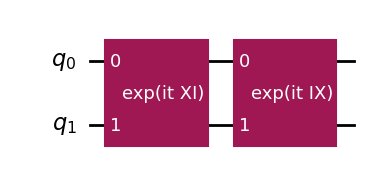

In [650]:
# Exemple d'utilisation de la fonction
n = 2
beta = 0.2
circuit = U_m(n, beta)
circuit.decompose().draw("mpl")

## 3.3 Build $U_c$

In [655]:
def U_c(n, hamiltonian, alpha):
    """
    Constructs a quantum circuit for a Hamiltonian evolution operation based on a given adjacency matrix.
    
    Parameters:
        n (int): The number of qubits.
        hamiltonian (list of lists or ndarray): The adjacency matrix representing the graph or quadratic Hamiltonian.
            The matrix is assumed to be symmetric, where non-zero entries indicate edges or interactions between qubits.
        alpha (float): Evolution time, representing the scale of the Hamiltonian operation.
    
    Returns:
        QuantumCircuit: A quantum circuit with a Hamiltonian evolution gate applied to `n` qubits.
    """
    
    def interaction(hamiltonian):
        """
        Identifies pairs of indices (i, j) in the adjacency matrix where there is a non-zero entry.
        
        Parameters:
            hamiltonian (list of lists or ndarray): The adjacency matrix of the graph.
        
        Returns:
            list of tuple: A list of tuples, each representing a non-zero entry (i, j) in the adjacency matrix.
        """
        non_nuls = []
        for i, row in enumerate(hamiltonian):
            for j, element in enumerate(row):
                if element != 0:
                    non_nuls.append((i, j))
        return non_nuls

    # Find all non-zero interactions in the Hamiltonian matrix
    list_of_connection = interaction(hamiltonian)
    
    # Define Pauli operators and identity matrix
    I = SparsePauliOp("I")  # Identity operator
    Z = SparsePauliOp("Z")  # Pauli Z operator
    
    # Initialize an empty operator for summing terms
    operator_total = None

    # Loop over all pairs (i, j) of interacting qubits to construct the Hamiltonian operator
    for (i, j) in list_of_connection:
        # Create a list of `I` operators for the tensor product
        A = [I] * n
        # Replace the i-th and j-th elements with `Z` operators to represent the interaction
        A[i] = Z
        A[j] = Z
        
        # Initialize the operator as the tensor product of all elements in A
        operator = A[0]
        for matrix in A[1:]:
            operator = operator ^ matrix  # Tensor product of operators
            
        # Sum all interaction terms to build the complete Hamiltonian operator
        if operator_total is None:
            operator_total = operator
        else:
            operator_total += operator
    
    # Construct the evolution gate based on the Hamiltonian
    evo = PauliEvolutionGate(operator_total, time=alpha)

    # Create a quantum circuit and apply the evolution gate to all qubits
    circuit = QuantumCircuit(n)
    circuit.append(evo, range(n))

    return circuit


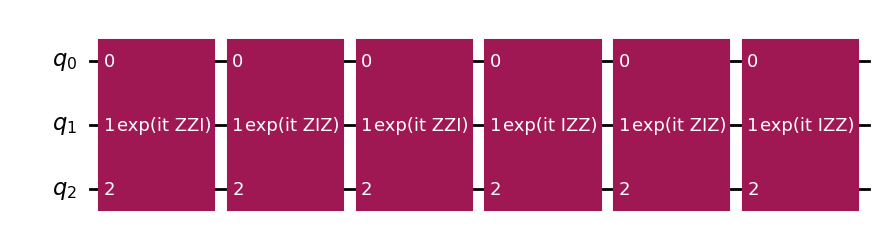

In [656]:
# Exemple d'utilisation de la fonction
n = 3
adjence_matrix = matrices_adj[0]
t = 0.2
circuit = U_c(n, adjence_matrix, t)
circuit.decompose().draw("mpl")

## 3.4 QAOA solver

In [ ]:
def cost_function(hamiltonian, alpha, beta):
    """
    This function computes the cost of the quantum state |phi> as C = <phi|H_c|phi>.
    
    Parameters:
    - hamiltonian (ndarray): The adjacency matrix representing the problem Hamiltonian.
    - alpha (list[float]): List of angles for the cost Hamiltonian gates in the QAOA circuit.
    - beta (list[float]): List of angles for the mixing Hamiltonian gates in the QAOA circuit.

    Returns:
    - cost (float): The cost value C = <phi|H_c|phi>, representing the expected energy of the state.
    - psi_state (ndarray): The final statevector |phi> after applying the QAOA circuit.
    """
    
    def u_qaoa(alpha, beta):
        """
        Constructs the QAOA unitary circuit by sequentially applying mixing and cost operators.
        
        Parameters:
        - alpha (list[float]): Parameters for the cost Hamiltonian gates.
        - beta (list[float]): Parameters for the mixing Hamiltonian gates.
        
        Returns:
        - QuantumCircuit: The QAOA circuit with alternating layers of cost and mixing operators.
        """
        circuit = QuantumCircuit(qubit_number)
        for a, b in zip(alpha, beta):
            circuit = circuit.compose(U_m(qubit_number, b))   # Apply the mixing unitary
            circuit = circuit.compose(U_c(qubit_number, hamiltonian, a))  # Apply the cost unitary
        return circuit

    # Determine the number of qubits from the Hamiltonian matrix
    qubit_number = len(hamiltonian)
    
    # Initialize the quantum state |psi> with a custom initial state and apply QAOA layers
    psi_state_circuit = QuantumCircuit(qubit_number)
    psi_state_circuit = psi_state_circuit.compose(U_init(qubit_number))  # Custom initial state
    psi_state_circuit = psi_state_circuit.compose(u_qaoa(alpha, beta))  # QAOA circuit application

    # Compute the final statevector |phi> after applying the QAOA circuit
    psi_state = Statevector(psi_state_circuit).data

    def ising_hamiltonian_builder(hamiltonian):
        """
        Builds the Ising Hamiltonian operator matrix from the adjacency matrix.
        
        Parameters:
        - hamiltonian (ndarray): The adjacency matrix representing qubit interactions.
        
        Returns:
        - ising_hamiltonian (ndarray): The Ising Hamiltonian matrix for the system.
        """
        ising_hamiltonian = None
        
        def interaction(hamiltonian):
            """Extracts non-zero entries representing qubit pairs with interactions."""
            non_nuls = []
            for i, row in enumerate(hamiltonian):
                for j, element in enumerate(row):
                    if element != 0:
                        non_nuls.append((i, j))
            return non_nuls

        list_of_connection = interaction(hamiltonian)
        I = np.eye(2)  # Identity matrix for each qubit
        Z = np.array([[1, 0], [0, -1]])  # Pauli-Z matrix

        # Loop through each qubit pair to construct and sum interaction operators
        for (i, j) in list_of_connection:
            # Create a vector of identity matrices
            A = [I] * qubit_number
            # Replace the i-th and j-th elements with Pauli-Z matrices
            A[i] = Z
            A[j] = Z
            # Initialize the operator with the first matrix in the vector
            operator = A[0]
            # Perform tensor products to construct the full operator
            for matrix in A[1:]:
                operator = np.kron(operator, matrix)
            # Sum operators to build the Hamiltonian
            if ising_hamiltonian is None:
                ising_hamiltonian = operator
            else:
                ising_hamiltonian += operator
            
        return ising_hamiltonian

    # Compute the cost C = <phi|H_c|phi>
    cost = psi_state.conj().T @ ising_hamiltonian_builder(hamiltonian) @ psi_state
    
    return cost.real, psi_state


In [663]:
# Optimization of alpha and beta parameters for a Quantum Approximate Optimization Algorithm (QAOA)
def qaoa_solver(hamiltonian, alpha_init, beta_init):
    """
    This function optimizes the parameters alpha and beta for a QAOA circuit,
    aiming to minimize the cost function associated with a given Hamiltonian.

    Parameters:
    - hamiltonian (array-like): The Hamiltonian of the system, representing the 
      problem instance to be solved. This is used to evaluate the cost function.
    - alpha_init (array-like): Initial values for the alpha parameters in the QAOA circuit.
      These are angles in the QAOA ansatz that help define the solution state.
    - beta_init (array-like): Initial values for the beta parameters in the QAOA circuit.
      Like alpha, these angles define the solution state in the QAOA ansatz.

    Returns:
    - probability_dict (dict): A dictionary where each key is a binary string representing
      a quantum state, and each value is the probability of measuring that state after
      applying the optimized QAOA circuit. This dictionary gives the probability distribution
      of the optimized quantum state.
    """
    
    best_cost = np.inf  # Initialize the minimum cost to infinity
    best_psi_state = None  # Initialize the optimal quantum state as None

    # Define the cost function for optimization
    def combined_cost(params):
        nonlocal best_cost, best_psi_state

        # Split the parameters into alpha and beta components
        alpha = params[:len(alpha_init)]
        beta = params[len(alpha_init):]

        # Compute the cost and corresponding quantum state for the current parameters
        cost, psi_state = cost_function(hamiltonian, alpha, beta)
        
        # Update if a lower cost is found
        if cost < best_cost:
            best_cost = cost
            best_psi_state = psi_state  # Store the quantum state corresponding to the minimal cost
            
        return cost  # Return the cost for minimization

    # Concatenate initial alpha and beta parameters into a single array for optimization
    initial_params = np.concatenate([alpha_init, beta_init])

    # Call the scipy minimize function to find the optimal parameters
    result = minimize(combined_cost,
                      initial_params, 
                      method='Cobyla',
                      options={'disp': False})

    # Extract optimized alpha and beta parameters from result
    optimized_params = result.x
    alpha_opt = optimized_params[:len(alpha_init)]
    beta_opt = optimized_params[len(alpha_init):]

    # Determine the size of the quantum state and the number of bits needed for indexing
    num_elements = len(best_psi_state)
    num_bits = int(np.log2(num_elements))  # Calculate number of bits needed to index each element

    # Create a dictionary to store the probability distribution of the optimized state
    probability_dict = {}

    for i in range(num_elements):
        # Convert index i to a binary string with length equal to num_bits
        binary_key = format(i, f'0{num_bits}b')
        
        # Calculate the probability by taking the squared magnitude of the amplitude
        probability = abs(best_psi_state[i])**2
        
        # Store the probability in the dictionary with the binary string as the key
        probability_dict[binary_key] = probability

    # Return the probability distribution dictionary of the optimized quantum state
    return probability_dict


In [668]:
import matplotlib.pyplot as plt

# Post-processing function to plot a histogram of bit strings
def plot_top_histogram(bit_dict):
    """
    Plots a histogram of the top bit strings from a dictionary, filtering out complementary bit strings.
    
    Parameters:
    - bit_dict (dict): A dictionary where keys are bit strings (str) and values are associated numerical values (int or float).
    
    Returns:
    - None: This function directly displays a histogram plot.
    
    The function performs the following steps:
    1. Removes complementary bit strings (e.g., '001' and '110' are complements) from the dictionary.
    2. Selects the top 10 entries with the highest values.
    3. Displays bit positions of zeros and ones for each selected bit string.
    4. Colors the histogram bars based on specific bit strings.

    Helper functions:
    - remove_complementary_bits(bit_dict): Filters out complementary bit strings from the input dictionary.
    - get_bit_positions(bit_string): Returns the positions of zeros and ones in a bit string.
    """
    
    def remove_complementary_bits(bit_dict):
        """
        Removes complementary bit strings from the dictionary.
        
        Parameters:
        - bit_dict (dict): Original dictionary with bit strings as keys.
        
        Returns:
        - unique_bits (dict): Dictionary excluding complementary bit strings.
        """
        unique_bits = {}
        for bits, value in bit_dict.items():
            # Generate complementary bit string
            complement = ''.join('1' if b == '0' else '0' for b in bits)
            if complement in unique_bits:
                continue
            unique_bits[bits] = value
        return unique_bits
    
    def get_bit_positions(bit_string):
        """
        Determines the positions of zeros and ones in a bit string.
        
        Parameters:
        - bit_string (str): A string of bits (e.g., '001011').
        
        Returns:
        - pos_zeros (list of int): List of positions where the bit is '0'.
        - pos_ones (list of int): List of positions where the bit is '1'.
        """
        pos_zeros = [i for i, bit in enumerate(bit_string) if bit == '0']
        pos_ones = [i for i, bit in enumerate(bit_string) if bit == '1']
        return pos_zeros, pos_ones

    # Remove redundant and complementary bit strings
    unique_bits = remove_complementary_bits(bit_dict)
    
    # Sort items by values in descending order and keep the top 10 largest
    top_10 = sorted(unique_bits.items(), key=lambda item: item[1], reverse=True)[:10]
    bit_strings, values = zip(*top_10)
    
    # Display positions of 0s and 1s for each selected bit string
    for bit_string in bit_strings:
        pos_zeros, pos_ones = get_bit_positions(bit_string)
        print(f"Bit string: {bit_string}")
        print(f"Set 1: {pos_zeros}")
        print(f"Set 2: {pos_ones}\n")
    
    # Generate color dictionary for bar colors based on specific bit strings
    indexes = ["001", "010", "011", "00011", "01100", "01110", "01011", "011011", "011100", "011010", "001110", "0010111"]
    color_dict = {key: "r" if key in indexes else "g" for key in bit_strings}
    
    # Plot histogram
    plt.figure(figsize=(6, 3))
    plt.bar(bit_strings, values, width=0.3, color=[color_dict[key] for key in bit_strings])
    plt.xlabel('Bit strings')
    plt.ylabel('Values')
    plt.xticks(rotation=90)
    plt.show()


### A. graphe 1

Bit string: 010
Set 1: [0, 2]
Set 2: [1]

Bit string: 001
Set 1: [0, 1]
Set 2: [2]

Bit string: 011
Set 1: [0]
Set 2: [1, 2]

Bit string: 000
Set 1: [0, 1, 2]
Set 2: []



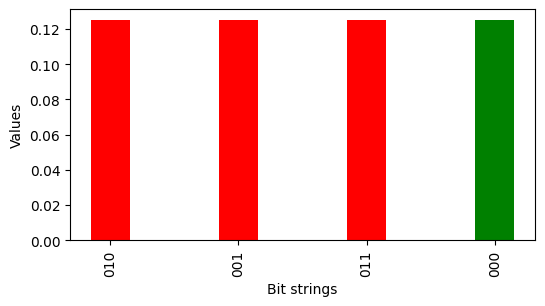

In [669]:
# Paramètres initiaux
alpha_init = [np.pi]  # Valeur initiale de alpha
beta_init = [np.pi]  # Valeur initiale de beta

result_1 =qaoa_solver(matrices_adj[0] , alpha_init , beta_init)
plot_top_histogram(result_1)

### B. Graphe 2

Bit string: 00101
Set 1: [0, 1, 3]
Set 2: [2, 4]

Bit string: 01110
Set 1: [0, 4]
Set 2: [1, 2, 3]

Bit string: 01011
Set 1: [0, 2]
Set 2: [1, 3, 4]

Bit string: 00011
Set 1: [0, 1, 2]
Set 2: [3, 4]

Bit string: 01100
Set 1: [0, 3, 4]
Set 2: [1, 2]

Bit string: 01101
Set 1: [0, 3]
Set 2: [1, 2, 4]

Bit string: 00111
Set 1: [0, 1]
Set 2: [2, 3, 4]

Bit string: 01000
Set 1: [0, 2, 3, 4]
Set 2: [1]

Bit string: 00010
Set 1: [0, 1, 2, 4]
Set 2: [3]

Bit string: 00110
Set 1: [0, 1, 4]
Set 2: [2, 3]



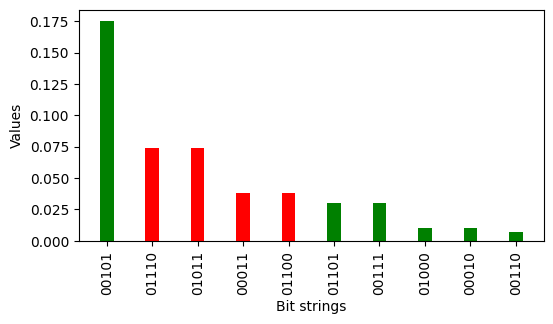

In [670]:
# Paramètres initiaux
alpha_init = [10 , 10 , 10 , 10]  # Valeur initiale de alpha
beta_init = [10 , 10 , 10 , 10]  # Valeur initiale de beta

result_2 =qaoa_solver(matrices_adj[1] , alpha_init , beta_init)
plot_top_histogram(result_2)

### C. graph 3

bit string: 011010
Set 1: [0, 3, 5]
Set 2: [1, 2, 4]

bit string: 001100
Set 1: [0, 1, 4, 5]
Set 2: [2, 3]

bit string: 001110
Set 1: [0, 1, 5]
Set 2: [2, 3, 4]

bit string: 011100
Set 1: [0, 4, 5]
Set 2: [1, 2, 3]

bit string: 010011
Set 1: [0, 2, 3]
Set 2: [1, 4, 5]



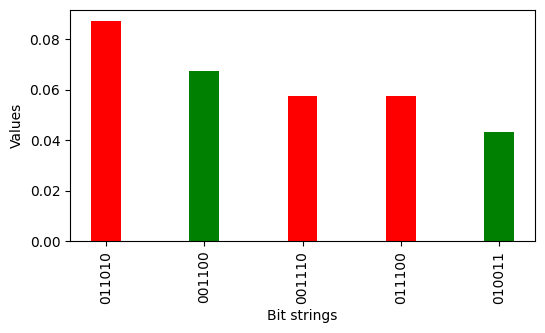

In [612]:
# Paramètres initiaux
alpha_init = [10 , 10 , 10 , 10]  # Valeur initiale de alpha
beta_init = [10 , 10 , 10 , 10]  # Valeur initiale de beta

result_3 =qaoa_solver(matrices_adj[2] , alpha_init , beta_init)
plot_top_histogram(result_3)

### D. Graph 4

In [671]:
# Paramètres initiaux
alpha_init = [10 , 10 , 10 , 10 , 10 , 10 , 10 , 10]  # Valeur initiale de alpha
beta_init = [10 , 10 , 10 , 10 , 10 , 10 , 10 , 10]  # Valeur initiale de beta

result_4 =qaoa_solver(matrices_adj[3] , alpha_init , beta_init)
plot_top_histogram(result_4)

KeyboardInterrupt: 

# 4. Quantum annealer with Pulser

In [672]:
from pulser import DigitalAnalogDevice, Register, Pulse, Sequence
from pulser_simulation import QutipEmulator
from pulser.waveforms import RampWaveform
from pulser.devices import MockDevice


In [673]:
from scipy.spatial.distance import pdist , squareform
def evaluate_mapping(new_coords, Q):
    """
    A cost function to evaluate the difference between the pairwise distances of 
    the given coordinates and the target matrix Q. This is used to minimize the 
    error in the spatial mapping based on some interaction model (inverse sixth power law).
    
    Parameters:
    new_coords (array-like): A 1D array of length 2N, representing the x and y coordinates
                              of N points in a 2D space. It needs to be reshaped into an
                              N x 2 array for processing.
    Q (array-like): A 2D array of shape (N, N) representing the target matrix of pairwise
                    distances between N points, which we aim to preserve in the new coordinate 
                    system. Typically, Q is a symmetric matrix.
    
    Returns:
    float: The norm of the difference between the computed pairwise interaction matrix and Q.
           This value is used as the cost for optimization. A lower value indicates a better
           match between the pairwise distances of `new_coords` and `Q`.
    
    Comments:
    - The function reshapes `new_coords` into an N x 2 array to represent the coordinates of N points in 2D.
    - It then calculates the pairwise distances between the points using the `pdist` function from `scipy.spatial.distance`.
    - The computed distances are transformed using the inverse sixth power law (the interaction model) to create a new matrix `new_Q`.
    - The cost is calculated as the Frobenius norm of the difference between `new_Q` and the target matrix `Q`, representing the error in the mapping.
    """

    # Reshaping new_coords to a 2D array of shape (N, 2), where N is the number of points.
    new_coords = np.reshape(new_coords, (len(Q), 2))
    
    # Computing the pairwise distances between the new coordinates.
    # pdist returns a condensed distance matrix, and squareform converts it into a full symmetric matrix.
    new_Q = squareform(
        DigitalAnalogDevice.interaction_coeff / pdist(new_coords)**6
    )
    
    # Returning the Frobenius norm of the difference between the computed and target matrices.
    return np.linalg.norm(new_Q - Q)


In [ ]:
# def optimize_sequence(Omega , t_rise , delta_0 , T , registre,hamiltonian):
#     """ Fonction pour optimiser la séquence 
#     Input: 
#     - Omega: frequence de Rabi
#     - t_rise: temps pour atteindre omega
#     - delta_0: detuning
#     - registre: la disposition des atomes
#     - hamiltonian: la matrice d'adjence

#     """
#     Omega = np.abs(Omega)
#     rise = Pulse.ConstantDetuning(
#         amplitude=RampWaveform(duration=t_rise, start=0.0, stop=Omega), 
#         detuning=delta_0,  # Initial detuning for the rise
#         phase=0.0,
#         )

#     # Create the sweep pulse with the filtered (smoothed) detuning profile
#     delta_f = -delta_0
#     sweep = Pulse.ConstantAmplitude(
#         amplitude=Omega,  # Use the same amplitude for the sweep
#         detuning=RampWaveform(duration= T, start = delta_0 , stop = delta_f),
#         phase=0.0,
#         )

#     # Create the fall pulse with smooth detuning
#     t_fall = t_rise
#     fall = Pulse.ConstantDetuning(
#         amplitude=RampWaveform(duration=t_fall, start=Omega, stop=0.0), 
#         detuning=delta_f,  # Last value in the detuning profile
#         phase=0.0,
#     )

#         # Create the sequence and add the pulses to it
#     #seq = Sequence(Register_list[0], device=MockDevice)
#     seq = Sequence(registre ,device=MockDevice)
#     seq.declare_channel('ising', 'rydberg_global')
#     seq.add(rise, 'ising', "no-delay")
#     seq.add(sweep, 'ising', "no-delay")
#     seq.add(fall, 'ising', "no-delay")


#     simul = QutipEmulator.from_sequence(seq)
    
#     def ising_hamiltonian_builder(hamiltonian):
#         qubit_number= len(hamiltonian)
#         ising_hamiltonian = None
#         def interaction(hamiltonian):
#             non_nuls = []
#             for i, ligne in enumerate(hamiltonian):
#                 for j, element in enumerate(ligne):
#                     if element != 0:
#                         non_nuls.append((i, j))
#             return non_nuls

#         list_of_connection = interaction(hamiltonian)
#         I = np.eye(2)
#         Z = np.array([
#             [1 ,0],
#             [0  ,-1]
#         ])

#         # Boucle pour créer les opérateurs et les additionner
#         for (i, j) in list_of_connection:
#             # Créer un vecteur de matrices I
#             A = [I] * qubit_number
#             # Remplacer les ième et jième éléments par Z
#             A[i] = Z
#             A[j] = Z
#             # Initialiser l'opérateur avec la première matrice du vecteur
#             operator = A[0]
#             # Boucle pour effectuer les produits tensoriels
#             for matrix in A[1:]:
#                 operator = np.kron(operator , matrix)
#             # Additionner les opérateurs
#             if ising_hamiltonian is None:
#                 ising_hamiltonian = operator
#             else:
#                 ising_hamiltonian += operator
            
#         return ising_hamiltonian


#     #H = simul.get_hamiltonian(T)
#     H = ising_hamiltonian_builder(hamiltonian)
#     results = simul.run()
#     final_state = results.get_final_state()
#     cost = final_state.full().conj().T @ H @ final_state.full()
    
#     return cost


# def annealing_cost(params, registre , hamiltonian):
#     Omega, t_rise, delta_0, T =  np.round(params)
#     return optimize_sequence(Omega, t_rise, delta_0, T, registre , hamiltonian).real  # Utilisez .real pour obtenir uniquement la partie réelle

In [674]:
def optimize_sequence(Omega , t_rise , delta_0 , T , registre, hamiltonian):
    """
    Function to optimize the sequence of pulses for a quantum system in the context of an Ising model simulation.
    
    Inputs:
    - Omega: Frequency of the Rabi oscillation (float)
      This is the amplitude of the Rabi oscillation, representing the driving field strength applied to the system.
    - t_rise: Rise time for the pulse (float)
      This is the time it takes for the Rabi frequency to ramp up from zero to Omega.
    - delta_0: Detuning value at the start (float)
      This is the initial detuning value, which controls the energy offset between the system's states.
    - T: Duration of the sweep pulse (float)
      This is the time for which the detuning will evolve, driving the system's behavior during the pulse.
    - registre: Register configuration (list or array)
      The arrangement of atoms or qubits in the quantum system, represented as a register of states or positions.
    - hamiltonian: Hamiltonian matrix (2D array or matrix)
      The Hamiltonian represents the energy interactions in the system. It is used to calculate the cost function after simulating the pulse sequence.
    
    Outputs:
    - cost: The final cost after optimizing the sequence (float)
      This is the energy cost (expectation value of the Hamiltonian) after running the pulse sequence on the quantum system.

    """
    # Ensure Omega is positive
    Omega = np.abs(Omega)
    
    # Create a rise pulse (constant detuning with ramped amplitude)
    rise = Pulse.ConstantDetuning(
        amplitude=RampWaveform(duration=t_rise, start=0.0, stop=Omega), 
        detuning=delta_0,  # Initial detuning for the rise
        phase=0.0,
    )

    # Create the sweep pulse (constant amplitude, ramped detuning)
    delta_f = -delta_0  # Final detuning value after the sweep
    sweep = Pulse.ConstantAmplitude(
        amplitude=Omega,  # Same amplitude for the sweep as the rise
        detuning=RampWaveform(duration=T, start=delta_0, stop=delta_f),
        phase=0.0,
    )

    # Create the fall pulse (constant detuning with ramped amplitude)
    t_fall = t_rise  # Fall time equal to rise time
    fall = Pulse.ConstantDetuning(
        amplitude=RampWaveform(duration=t_fall, start=Omega, stop=0.0), 
        detuning=delta_f,  # Last detuning value from the sweep pulse
        phase=0.0,
    )

    # Create the pulse sequence and add the pulses
    seq = Sequence(registre, device=MockDevice)  # Create sequence for the register configuration
    seq.declare_channel('ising', 'rydberg_global')  # Declare a channel for interaction
    seq.add(rise, 'ising', "no-delay")  # Add the rise pulse
    seq.add(sweep, 'ising', "no-delay")  # Add the sweep pulse
    seq.add(fall, 'ising', "no-delay")  # Add the fall pulse

    # Set up the simulator with the sequence
    simul = QutipEmulator.from_sequence(seq)
    
    # Define the Ising Hamiltonian for the simulation based on the given Hamiltonian matrix
    def ising_hamiltonian_builder(hamiltonian):
        qubit_number = len(hamiltonian)  # Number of qubits based on the Hamiltonian size
        ising_hamiltonian = None

        def interaction(hamiltonian):
            non_nuls = []  # Store non-zero interactions
            for i, row in enumerate(hamiltonian):
                for j, element in enumerate(row):
                    if element != 0:
                        non_nuls.append((i, j))  # Store the indices of non-zero elements
            return non_nuls

        # Get list of non-zero interactions in the Hamiltonian
        list_of_connection = interaction(hamiltonian)
        I = np.eye(2)  # Identity matrix for qubits
        Z = np.array([[1, 0], [0, -1]])  # Pauli-Z matrix
        
        # Loop through the non-zero interactions to create the Ising Hamiltonian
        for (i, j) in list_of_connection:
            # Create a vector of identity matrices for each qubit
            A = [I] * qubit_number
            A[i] = Z  # Replace the i-th qubit with Pauli-Z
            A[j] = Z  # Replace the j-th qubit with Pauli-Z
            operator = A[0]
            for matrix in A[1:]:
                operator = np.kron(operator, matrix)  # Compute the tensor product
            
            # Add the operator to the total Ising Hamiltonian
            if ising_hamiltonian is None:
                ising_hamiltonian = operator
            else:
                ising_hamiltonian += operator
        
        return ising_hamiltonian

    # Get the Ising Hamiltonian for the given Hamiltonian matrix
    H = ising_hamiltonian_builder(hamiltonian)
    
    # Run the simulation and get the final state
    results = simul.run()
    final_state = results.get_final_state()
    
    # Calculate the cost (expectation value of the Hamiltonian)
    cost = final_state.full().conj().T @ H @ final_state.full()
    
    return cost  # Return the cost, which is the energy expectation value


def annealing_cost(params, registre , hamiltonian):
    """
    Wrapper function to compute the cost for a given set of parameters.

    Inputs:
    - params: A list or array of parameters [Omega, t_rise, delta_0, T]
      These are the parameters that define the pulse sequence.
    - registre: The quantum register configuration (list or array).
    - hamiltonian: The Hamiltonian matrix (2D array or matrix).
    
    Output:
    - cost: The cost function value (float).
      This is the final cost returned by the optimize_sequence function.
    """
    # Round the input parameters for optimization
    Omega, t_rise, delta_0, T = np.round(params)
    
    # Call optimize_sequence to compute the cost
    return optimize_sequence(Omega, t_rise, delta_0, T, registre, hamiltonian).real  # Use .real to get the real part of the cost


In [678]:
import matplotlib.pyplot as plt

def process_bitstring_histogram(seq, N_samples=5000, min_frequence=10, indexes=None):
    """
    Processes a bit string sequence, filters the most frequent bit strings, removes complementary bit strings, 
    and visualizes the results in a histogram.

    Parameters:
    - seq (str): The bit string sequence to be processed.
    - N_samples (int, optional): Number of samples to run in the simulation (default is 5000).
    - min_frequence (int, optional): Minimum frequency to keep bit strings in the results (default is 10).
    - indexes (list, optional): List of indexes to highlight in the plot with a different color (default is None).
    
    Returns:
    - None: Displays a histogram plot with the results.
    """

    # Initialize the simulation with the provided sequence
    simul = QutipEmulator.from_sequence(seq)
    results = simul.run()  # Run the simulation
    final = results.get_final_state()  # Get the final state after the simulation
    count_dict = results.sample_final_state(N_samples=N_samples)  # Sample the final state

    # Filter out bit strings that occur less than the specified frequency
    def most_frequent(dictionnary, min_frequence):
        """
        Filters the bit string dictionary to keep only those with a frequency above the threshold.
        """
        return {k: v for k, v in dictionnary.items() if v > min_frequence}

    # Remove complementary bit strings (e.g., '010' and '101' are considered complementary)
    def remove_complementary_bits(bit_dict):
        """
        Removes complementary bit strings from the dictionary. A bit string and its complement 
        are considered as the same and only one will be kept.
        """
        unique_bits = {}
        for bits, value in bit_dict.items():
            # Generate the complement of the bit string
            complement = ''.join('1' if b == '0' else '0' for b in bits)
            # If the complement is not in the dictionary, add the bit string
            if complement not in unique_bits:
                unique_bits[bits] = value
        return unique_bits

    # Get the positions of 0s and 1s in a bit string
    def get_bit_positions(bit_string):
        """
        Returns the positions of 0s and 1s in the given bit string.
        """
        pos_zeros = [i for i, bit in enumerate(bit_string) if bit == '0']
        pos_ones = [i for i, bit in enumerate(bit_string) if bit == '1']
        return pos_zeros, pos_ones

    # Apply the filters to the sampled bit strings
    count_dict = most_frequent(count_dict, min_frequence)  # Keep only frequent bit strings
    unique_bits = remove_complementary_bits(count_dict)  # Remove complementary bit strings

    # Extract the unique bit strings and their values
    bit_strings, values = zip(*unique_bits.items())  # Unzip the dictionary into separate lists
    bit_positions = [get_bit_positions(bits) for bits in bit_strings]  # Get positions of 0s and 1s

    # Print the positions of 0s and 1s for each bit string
    for bit_string, (pos_zeros, pos_ones) in zip(bit_strings, bit_positions):
        print(f"Bit string: {bit_string}")
        print(f"Set 1 (positions of 0s): {pos_zeros}")
        print(f"Set 2 (positions of 1s): {pos_ones}\n")

    # Generate a dictionary for coloring the bars in the histogram
    if indexes is None:
        indexes = []  # If no indexes are provided, use an empty list
    color_dict = {key: "r" if key in indexes else "g" for key in bit_strings}  # Red for highlighted, green otherwise

    # Plot the histogram of bit strings and their values
    plt.figure(figsize=(6, 3))  # Set the figure size
    plt.bar(bit_strings, values, width=0.3, color=color_dict.values())  # Create a bar plot
    plt.xlabel('Bit Strings')  # Label for the x-axis
    plt.ylabel('Values')  # Label for the y-axis
    plt.xticks(rotation=90)  # Rotate the x-axis labels for better readability
    plt.show()  # Display the plot


### A. Graphe 1

c:\Users\isaac\anaconda3\envs\pulser_env\Lib\site-packages\scipy\optimize\_minimize.py:719: OptimizeWarning: Unknown solver options: maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


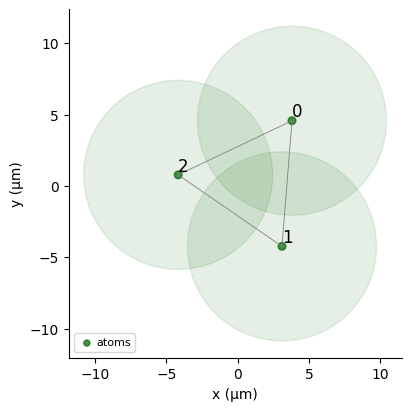

In [ ]:
np.random.seed(0)
x0_1 = np.random.random(len(matrices_adj[0])*2)
res = minimize(
    evaluate_mapping,
    x0_1,
    args=(matrices_adj[0],),
    #method="Nelder-Mead",
    method = "COBYLA",
    tol = 1e-6,
    options={"maxiter":10000, "maxfev":None}
)

coords = np.reshape(res.x , (len(matrices_adj[0]) , 2))

qubits = dict(enumerate(coords/1.5))
reg_graph_1 = Register(qubits=qubits)
reg_graph_1.draw(
blockade_radius=DigitalAnalogDevice.rydberg_blockade_radius(1),
draw_graph= True,
draw_half_radius=True)

In [677]:
# Choisissez des valeurs initiales pour les paramètres
params_initial = [2, 50, -18, 5000]  # Vous pouvez adapter les valeurs initiales

# Effectuez l'optimisation
result = minimize(annealing_cost, 
                  params_initial, 
                  args=(reg_graph_1,matrices_adj[0],),
                  #method='Cobyla'
                  method = 'Nelder-Mead'
                  )

# Affichez les résultats
optimal_params = result.x
optimal_cost = result.fun

print("Paramètres optimaux:", optimal_params)
print("Coût minimal:", optimal_cost)


Paramètres optimaux: [ 1.79803029e+00  3.80720305e+01 -1.25323780e+01  7.43712706e+03]
Coût minimal: -1.8658327200086262


In [578]:
opti_1 = list(np.around(optimal_params))

Omega , t_rise , delta_0 , T = opti_1
t_fall = t_rise
delta_f = - delta_0

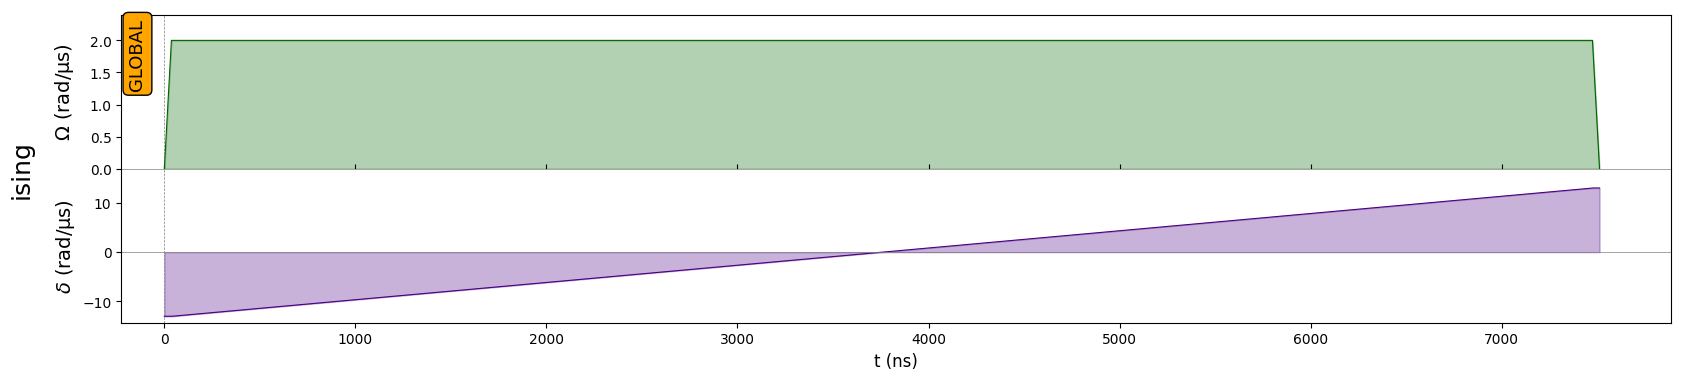

In [ ]:
 # Create the rise pulse with smooth detuning
rise = Pulse.ConstantDetuning(
    amplitude=RampWaveform(duration=t_rise, start=0.0, stop=Omega), 
    detuning=delta_0,  # Initial detuning for the rise
    phase=0.0,
)

    # Create the sweep pulse with the filtered (smoothed) detuning profile
sweep = Pulse.ConstantAmplitude(
    amplitude=Omega,  # Use the same amplitude for the sweep
    detuning=RampWaveform(duration= T, start = delta_0 , stop = delta_f),
    phase=0.0,
)

    # Create the fall pulse with smooth detuning
fall = Pulse.ConstantDetuning(
    amplitude=RampWaveform(duration=t_fall, start=Omega, stop=0.0), 
    detuning=delta_f,  # Last value in the detuning profile
    phase=0.0,
)

# Create the sequence and add the pulses to it

seq = Sequence(reg_graph_1 ,device=MockDevice)
seq.declare_channel('ising', 'rydberg_global')
seq.add(rise, 'ising', "no-delay")
seq.add(sweep, 'ising', "no-delay")
seq.add(fall, 'ising', "no-delay")
seq.draw()

bits string: 001
Set 1: [0, 1]
Set 2: [2]

bits string: 010
Set 1: [0, 2]
Set 2: [1]

bits string: 011
Set 1: [0]
Set 2: [1, 2]

bits string: 111
Set 1: []
Set 2: [0, 1, 2]



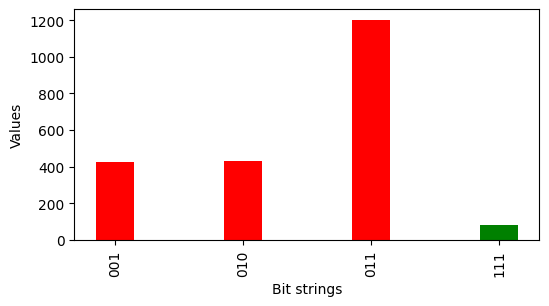

In [580]:
process_bitstring_histogram(seq , min_frequence=5 , indexes=["001" , "010" , "100", "110" , "101", "011"])

### B. Graph 2

c:\Users\isaac\anaconda3\envs\pulser_env\Lib\site-packages\scipy\optimize\_minimize.py:719: OptimizeWarning: Unknown solver options: maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


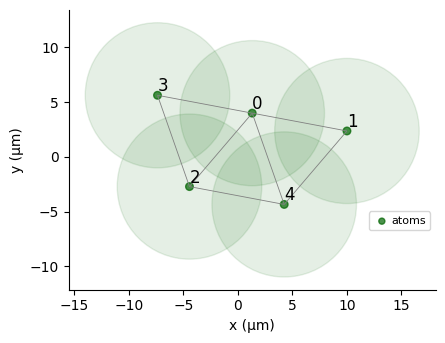

In [581]:
np.random.seed(0)
x0_2 = np.random.random(len(matrices_adj[1])*2)
res = minimize(
    evaluate_mapping,
    x0_2,
    args=(matrices_adj[1],),
    #method="Nelder-Mead",
    method = "COBYLA",
    tol = 1e-6,
    options={"maxiter":200000, "maxfev":None}
)

coords = np.reshape(res.x , (len(matrices_adj[1]) , 2))

qubits = dict(enumerate(coords/1.5))
reg_graph_2 = Register(qubits=qubits)
reg_graph_2.draw(
blockade_radius=DigitalAnalogDevice.rydberg_blockade_radius(1),
draw_graph= True,
draw_half_radius=True)

In [582]:
# Choisissez des valeurs initiales pour les paramètres
params_initial = [2, 50, -18, 5000]  # Vous pouvez adapter les valeurs initiales

# Effectuez l'optimisation
result = minimize(annealing_cost, 
                  params_initial, 
                  args=(reg_graph_2,matrices_adj[1],),
                  #method='Cobyla'
                  method = 'Nelder-Mead'
                  )

# Affichez les résultats
optimal_params = result.x
optimal_cost = result.fun

print("Paramètres optimaux:", optimal_params)
print("Coût minimal:", optimal_cost)

Paramètres optimaux: [ 1.79629926e+00  5.19870293e+01 -1.62125389e+01  6.41097797e+03]
Coût minimal: -5.293086525298691


In [583]:
opti_2 = list(np.around(optimal_params))

Omega , t_rise , delta_0 , T = opti_2
t_fall = t_rise
delta_f = - delta_0

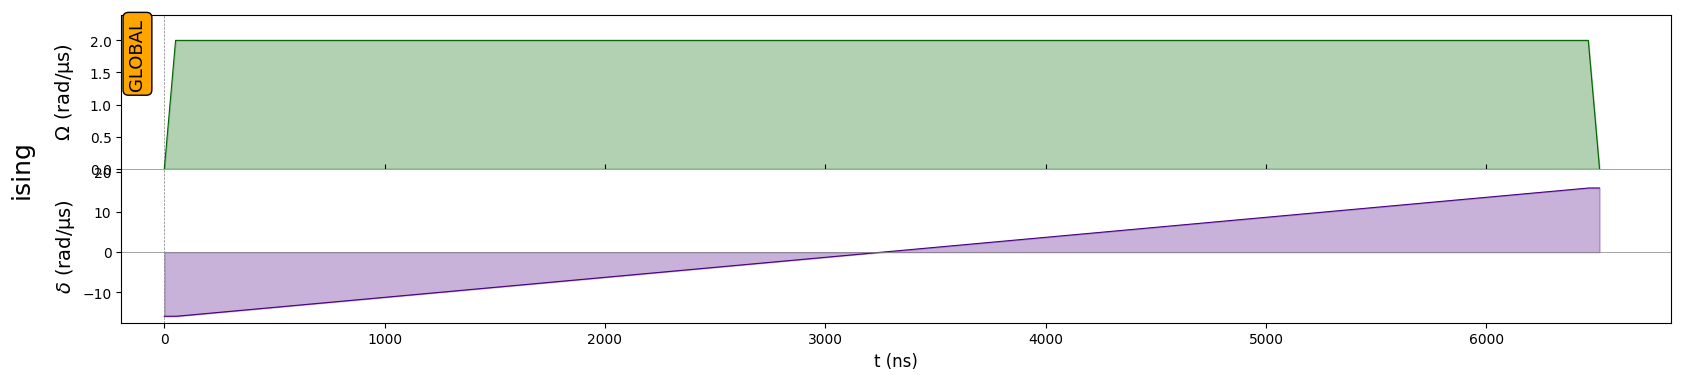

In [584]:
 # Create the rise pulse with smooth detuning
rise = Pulse.ConstantDetuning(
    amplitude=RampWaveform(duration=t_rise, start=0.0, stop=Omega), 
    detuning=delta_0,  # Initial detuning for the rise
    phase=0.0,
)

    # Create the sweep pulse with the filtered (smoothed) detuning profile
sweep = Pulse.ConstantAmplitude(
    amplitude=Omega,  # Use the same amplitude for the sweep
    detuning=RampWaveform(duration= T, start = delta_0 , stop = delta_f),
    phase=0.0,
)

    # Create the fall pulse with smooth detuning
fall = Pulse.ConstantDetuning(
    amplitude=RampWaveform(duration=t_fall, start=Omega, stop=0.0), 
    detuning=delta_f,  # Last value in the detuning profile
    phase=0.0,
)

    # Create the sequence and add the pulses to it
#seq = Sequence(Register_list[0], device=MockDevice)
seq = Sequence(reg_graph_2 ,device=MockDevice)
seq.declare_channel('ising', 'rydberg_global')
seq.add(rise, 'ising', "no-delay")
seq.add(sweep, 'ising', "no-delay")
seq.add(fall, 'ising', "no-delay")
seq.draw()

bits string: 00000
Set 1: [0, 1, 2, 3, 4]
Set 2: []

bits string: 00001
Set 1: [0, 1, 2, 3]
Set 2: [4]

bits string: 00011
Set 1: [0, 1, 2]
Set 2: [3, 4]

bits string: 00100
Set 1: [0, 1, 3, 4]
Set 2: [2]

bits string: 00101
Set 1: [0, 1, 3]
Set 2: [2, 4]

bits string: 00110
Set 1: [0, 1, 4]
Set 2: [2, 3]

bits string: 00111
Set 1: [0, 1]
Set 2: [2, 3, 4]

bits string: 01000
Set 1: [0, 2, 3, 4]
Set 2: [1]

bits string: 01010
Set 1: [0, 2, 4]
Set 2: [1, 3]

bits string: 01011
Set 1: [0, 2]
Set 2: [1, 3, 4]

bits string: 01100
Set 1: [0, 3, 4]
Set 2: [1, 2]

bits string: 01101
Set 1: [0, 3]
Set 2: [1, 2, 4]

bits string: 01110
Set 1: [0, 4]
Set 2: [1, 2, 3]

bits string: 01111
Set 1: [0]
Set 2: [1, 2, 3, 4]



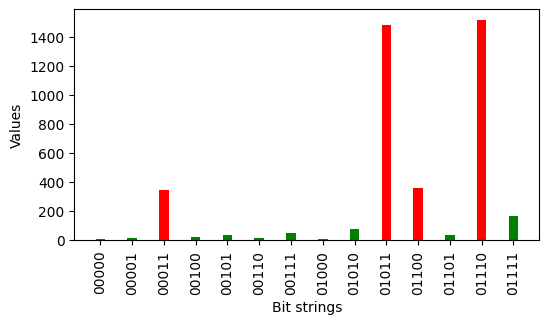

In [585]:
process_bitstring_histogram(seq , 
                            indexes = ["00011" , "11100" , "01100", "10011" ,  "01110" , "10001", "01011" , "10100"]
)

### C. Graph 3

c:\Users\isaac\anaconda3\envs\pulser_env\Lib\site-packages\scipy\optimize\_minimize.py:719: OptimizeWarning: Unknown solver options: maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


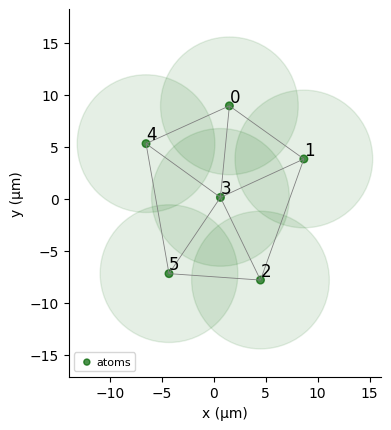

In [ ]:
np.random.seed(0)
x0_3 = np.random.random(len(matrices_adj[2])*2)
res = minimize(
    evaluate_mapping,
    x0_3,
    args=(matrices_adj[2],),
    #method="Nelder-Mead",
    method = "COBYLA",
    tol = 1e-6,
    options={"maxiter":200000, "maxfev":None}
)

coords = np.reshape(res.x , (len(matrices_adj[2]) , 2))

qubits = dict(enumerate(coords/1.5))
reg_graph_3 = Register(qubits=qubits)
reg_graph_3.draw(
blockade_radius=DigitalAnalogDevice.rydberg_blockade_radius(1),
draw_graph= True,
draw_half_radius=True)

In [587]:
# Choisissez des valeurs initiales pour les paramètres
params_initial = [2, 50, -18, 5000]  # Vous pouvez adapter les valeurs initiales

# Effectuez l'optimisation
result = minimize(annealing_cost, 
                  params_initial, 
                  args=(reg_graph_3,matrices_adj[2],),
                  #method='Cobyla'
                  method = 'Nelder-Mead'
                  )

# Affichez les résultats
optimal_params = result.x
optimal_cost = result.fun

print("Paramètres optimaux:", optimal_params)
print("Coût minimal:", optimal_cost)

Paramètres optimaux: [ 1.83680259e+00  5.13658926e+01 -1.57866894e+01  6.24304875e+03]
Coût minimal: -5.025742869436283


In [588]:
opti_3 = list(np.around(optimal_params))

Omega , t_rise , delta_0 , T = opti_3
t_fall = t_rise
delta_f = - delta_0

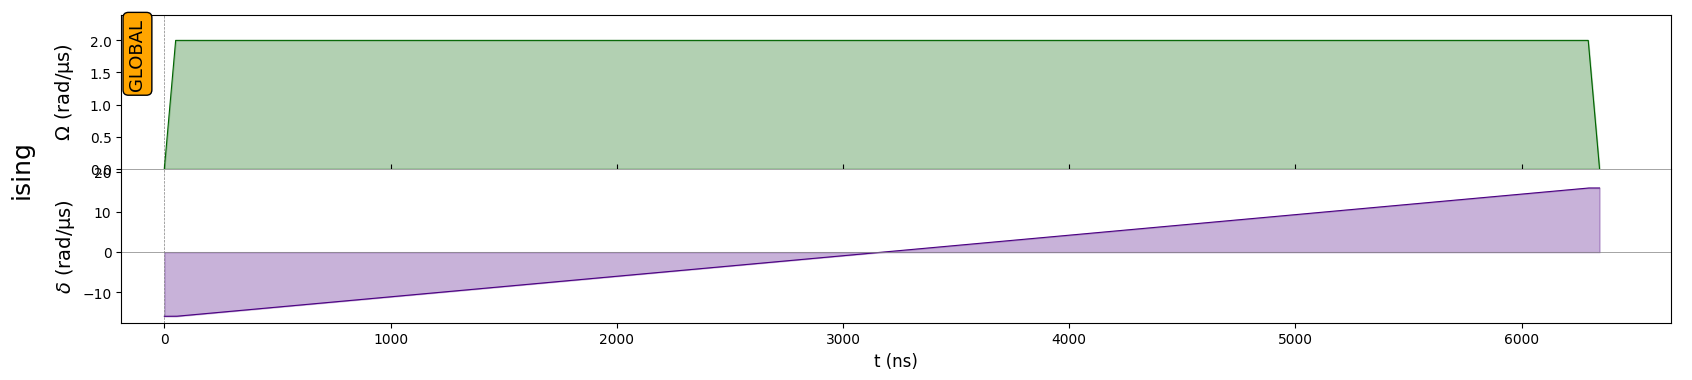

In [589]:
 # Create the rise pulse with smooth detuning
rise = Pulse.ConstantDetuning(
    amplitude=RampWaveform(duration=t_rise, start=0.0, stop=Omega), 
    detuning=delta_0,  # Initial detuning for the rise
    phase=0.0,
)

    # Create the sweep pulse with the filtered (smoothed) detuning profile
sweep = Pulse.ConstantAmplitude(
    amplitude=Omega,  # Use the same amplitude for the sweep
    detuning=RampWaveform(duration= T, start = delta_0 , stop = delta_f),
    phase=0.0,
)

    # Create the fall pulse with smooth detuning
fall = Pulse.ConstantDetuning(
    amplitude=RampWaveform(duration=t_fall, start=Omega, stop=0.0), 
    detuning=delta_f,  # Last value in the detuning profile
    phase=0.0,
)

    # Create the sequence and add the pulses to it
#seq = Sequence(Register_list[0], device=MockDevice)
seq = Sequence(reg_graph_3 ,device=MockDevice)
seq.declare_channel('ising', 'rydberg_global')
seq.add(rise, 'ising', "no-delay")
seq.add(sweep, 'ising', "no-delay")
seq.add(fall, 'ising', "no-delay")
seq.draw()

bits string: 000011
Set 1: [0, 1, 2, 3]
Set 2: [4, 5]

bits string: 001011
Set 1: [0, 1, 3]
Set 2: [2, 4, 5]

bits string: 001110
Set 1: [0, 1, 5]
Set 2: [2, 3, 4]

bits string: 010001
Set 1: [0, 2, 3, 4]
Set 2: [1, 5]

bits string: 010010
Set 1: [0, 2, 3, 5]
Set 2: [1, 4]

bits string: 010011
Set 1: [0, 2, 3]
Set 2: [1, 4, 5]

bits string: 010101
Set 1: [0, 2, 4]
Set 2: [1, 3, 5]

bits string: 010111
Set 1: [0, 2]
Set 2: [1, 3, 4, 5]

bits string: 011000
Set 1: [0, 3, 4, 5]
Set 2: [1, 2]

bits string: 011001
Set 1: [0, 3, 4]
Set 2: [1, 2, 5]

bits string: 011010
Set 1: [0, 3, 5]
Set 2: [1, 2, 4]

bits string: 011011
Set 1: [0, 3]
Set 2: [1, 2, 4, 5]

bits string: 011110
Set 1: [0, 5]
Set 2: [1, 2, 3, 4]

bits string: 100011
Set 1: [1, 2, 3]
Set 2: [0, 4, 5]

bits string: 101001
Set 1: [1, 3, 4]
Set 2: [0, 2, 5]

bits string: 101011
Set 1: [1, 3]
Set 2: [0, 2, 4, 5]

bits string: 110010
Set 1: [2, 3, 5]
Set 2: [0, 1, 4]

bits string: 111000
Set 1: [3, 4, 5]
Set 2: [0, 1, 2]

bits strin

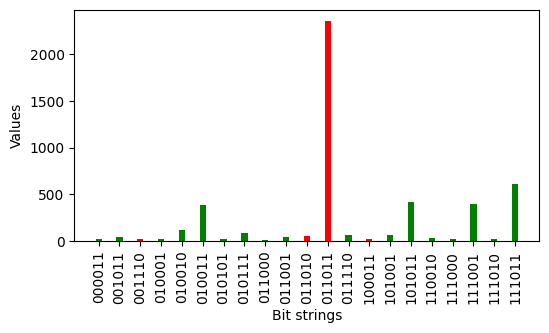

In [590]:
process_bitstring_histogram(seq , 
                            indexes = ["011011", "100100" , "011100" , "100011" , "011010" , "100101" , "001110" , "110001"]
)

### D. Graph 4

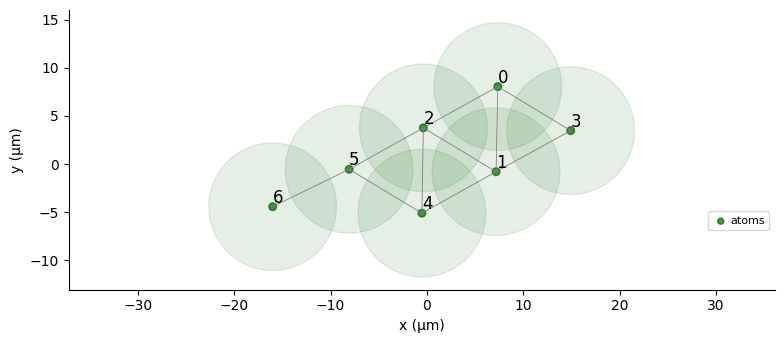

In [680]:
#np.random.seed(0)
x0_4 = np.random.random(len(matrices_adj[3])*2)
res = minimize(
    evaluate_mapping,
    x0_4,
    args=(matrices_adj[3],),
    #method="Nelder-Mead",
    method = "COBYLA",
    tol = 1e-6,
    options={"maxiter":1000000, "maxfev":None}
)

coords = np.reshape(res.x , (len(matrices_adj[3]) , 2))

qubits = dict(enumerate(coords/1.5))
reg_graph_4 = Register(qubits=qubits)
reg_graph_4.draw(
blockade_radius=DigitalAnalogDevice.rydberg_blockade_radius(1),
draw_graph= True,
draw_half_radius=True)

In [634]:
# Choisissez des valeurs initiales pour les paramètres
params_initial = [2, 50, -18, 10000]  # Vous pouvez adapter les valeurs initiales

# Effectuez l'optimisation
result = minimize(annealing_cost, 
                  params_initial, 
                  args=(reg_graph_4,matrices_adj[3],),
                  #method='Cobyla'
                  method = 'Nelder-Mead'
                  )

# Affichez les résultats
optimal_params = result.x
optimal_cost = result.fun

print("Paramètres optimaux:", optimal_params)
print("Coût minimal:", optimal_cost)

Paramètres optimaux: [ 2.05129800e+00  5.11108004e+01 -1.60460591e+01  1.07098708e+04]
Coût minimal: -4.442262019419368


In [623]:
opti_4 = list(np.around(optimal_params))

Omega , t_rise , delta_0 , T = opti_4
t_fall = t_rise
delta_f = - delta_0

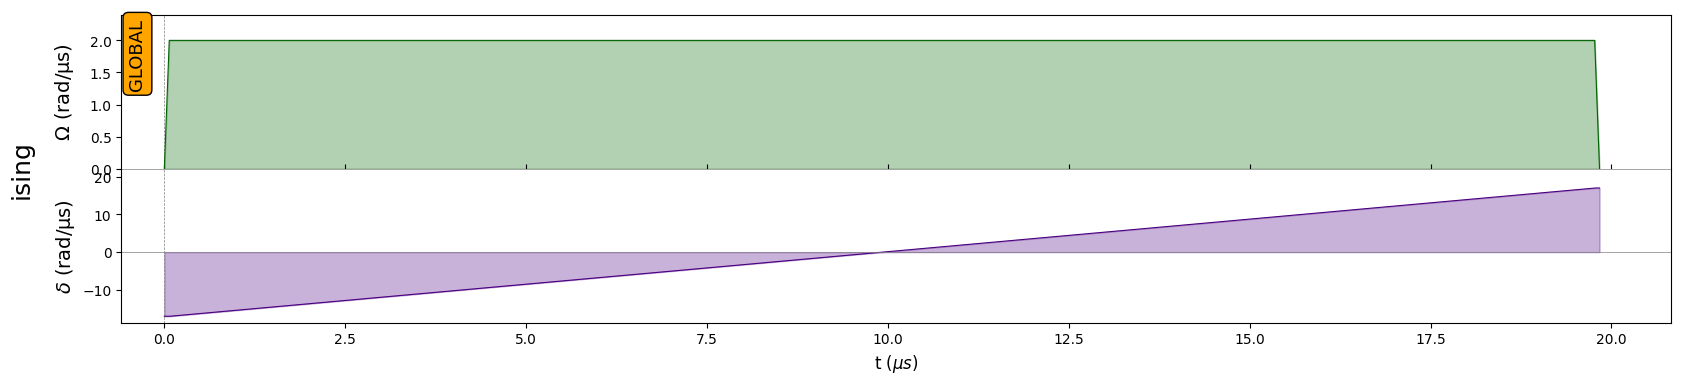

In [624]:
 # Create the rise pulse with smooth detuning
rise = Pulse.ConstantDetuning(
    amplitude=RampWaveform(duration=t_rise, start=0.0, stop=Omega), 
    detuning=delta_0,  # Initial detuning for the rise
    phase=0.0,
)

    # Create the sweep pulse with the filtered (smoothed) detuning profile
sweep = Pulse.ConstantAmplitude(
    amplitude=Omega,  # Use the same amplitude for the sweep
    detuning=RampWaveform(duration= 2*T, start = delta_0 , stop = delta_f),
    phase=0.0,
)

    # Create the fall pulse with smooth detuning
fall = Pulse.ConstantDetuning(
    amplitude=RampWaveform(duration=t_fall, start=Omega, stop=0.0), 
    detuning=delta_f,  # Last value in the detuning profile
    phase=0.0,
)

    # Create the sequence and add the pulses to it
#seq = Sequence(Register_list[0], device=MockDevice)
seq = Sequence(reg_graph_3 ,device=MockDevice)
seq.declare_channel('ising', 'rydberg_global')
seq.add(rise, 'ising', "no-delay")
seq.add(sweep, 'ising', "no-delay")
seq.add(fall, 'ising', "no-delay")
seq.draw()

bits string: 001011
Set 1: [0, 1, 3]
Set 2: [2, 4, 5]

bits string: 010010
Set 1: [0, 2, 3, 5]
Set 2: [1, 4]

bits string: 010011
Set 1: [0, 2, 3]
Set 2: [1, 4, 5]

bits string: 011001
Set 1: [0, 3, 4]
Set 2: [1, 2, 5]

bits string: 011010
Set 1: [0, 3, 5]
Set 2: [1, 2, 4]

bits string: 011011
Set 1: [0, 3]
Set 2: [1, 2, 4, 5]

bits string: 101011
Set 1: [1, 3]
Set 2: [0, 2, 4, 5]

bits string: 110011
Set 1: [2, 3]
Set 2: [0, 1, 4, 5]

bits string: 111001
Set 1: [3, 4]
Set 2: [0, 1, 2, 5]

bits string: 111010
Set 1: [3, 5]
Set 2: [0, 1, 2, 4]

bits string: 111011
Set 1: [3]
Set 2: [0, 1, 2, 4, 5]



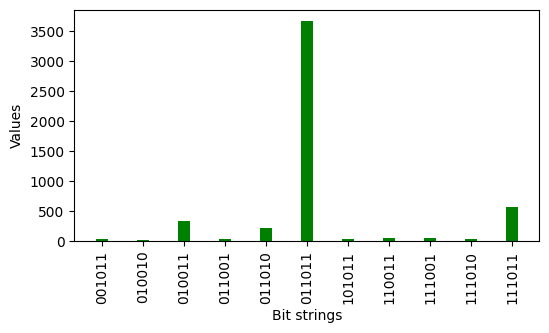

In [629]:
process_bitstring_histogram(seq = seq , 
                            min_frequence=10,
                            indexes = ["0010111" , "1101000"]
)

# Conclusion

In both cases, the solutions for each graph are clearly observed.

On the QAOA algorithm side, the search for the optimized circuit is heavily dependent on the number of parameters (which represents the depth of the algorithm), the initial values, and the graph itself. This is why we seek optimal parameters for each graph separately. The advantage of this algorithm is that it can find multiple solutions when there are several. However, if the number of qubits grows linearly with the problem size, we are quickly limited by the classical optimization of the parameters. Furthermore, finding an effective initialization of the parameters is not straightforward.

In the case of the annealer, the situation seems somewhat opposite, as the main challenge lies in the qubits. Indeed, finding a qubit placement that correctly maps the graph is complex. This mapping is crucial because a poor mapping could lead to a different graph, given that the problem is discrete. In addition to the placement of the qubits, we can significantly improve the algorithm's performance by optimizing the sequence parameters. This is what I did for each graph, always aiming to have the most suitable sequence profile for the graph.

Although both methods provide at least one satisfactory solution, there is still room for improvement, especially when dealing with large graphs. For example, for the annealer, implementing a more advanced sequence profile through interpolated waveforms could enhance performance.